<a href="https://colab.research.google.com/github/RGologorsky/fastmri/blob/master/DeepPit_1a_Affine_Alignment_MR_to_MR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Affine alignment

# Dependencies

In [135]:
# rigid alignment
!pip install itk-elastix

# simple itk
!pip install simpleitk

# viz
!pip install itkwidgets
!pip install neurite

# segmentation
!pip install meshio
!pip install nilearn

# Imports

In [212]:
# imports
import os, sys

# elastix-itk
import itk
from itkwidgets import compare, checkerboard, view

# simple itk
import SimpleITK as sitk

# numpy
import numpy as np
import nibabel as nib

# viz
import neurite as ne
import matplotlib
import matplotlib.pyplot as plt

# segmentation obj to binary np mask 
import nilearn as nil

from nibabel.affines import apply_affine
from scipy.spatial   import ConvexHull, Delaunay

import meshio

# Functions

## Seg2mask

Convert segmentation object to numpy binary mask

In [139]:
def seg2mask(image_path, segmentation_path):

  # import the .nii object
  dicom_img = nib.load(image_path)

  # import the segmentation mesh
  segmentation_mesh = meshio.read(segmentation_path)

  # Compute Delaunay triangulation of points.
  tri = Delaunay(segmentation_mesh.points)

  # define the voxel - realworld mappings 
  voxel_to_realworld_transform = dicom_img.affine
  realworld_to_voxel_transform = np.linalg.inv(voxel_to_realworld_transform)

  # initialize numpy arrays
  dicom_img_numpy_array = np.array(dicom_img.get_fdata())
  binary_segmentation_mask = np.zeros_like(dicom_img_numpy_array, dtype=np.bool_)

  # if you want to spot test a single slice, set the range to "range(80, dicom.shape[0])" this is a slice in the middle of the
  # MRI image which should be segmented. Then, uncomment the show_slices line to see the MRI and the segmentation

  # for readability
  shape0, shape1, shape2 = dicom_img_numpy_array.shape

  # from SO: https://stackoverflow.com/questions/12864445/how-to-convert-the-output-of-meshgrid-to-the-corresponding-array-of-points
  # equiv: np.array([(i,j,k) for i in range(shape0) for j in range(shape1) for k in range(shape2)])
  #voxel_location_array = np.array(np.meshgrid(range(shape0), range(shape1), range(shape2), indexing='ij')).T.reshape(-1, 3)[:,[2,1,0]]
  voxel_location_array = np.indices((shape2, shape1, shape0)).T.reshape(-1,3)[:,[2,1,0]]
  realworld_location_array = apply_affine(voxel_to_realworld_transform, voxel_location_array)
  binary_segmentation_mask = (tri.find_simplex(realworld_location_array) >= 0).reshape(shape0, shape1, shape2)

  return dicom_img_numpy_array, binary_segmentation_mask

## Viz fns

In [152]:
# Vz fns

def get_mid_idx(vol, ax): return vol.shape[ax]//2
def get_mid_idxs(vol): return [get_mid_idx(vol, ax=i) for i in (0, 1, 2)]

def viz_axes(vol, axes_idxs=[None, None, None]):

  slices, titles = [], []
  for ax in (0, 1, 2):
    idxs = axes_idxs[ax]
    if idx is None:           idxs = get_mid_idx(vol, ax)
    if isinstance(idxs, int): idxs = [idxs]

    titles += [f"Ax {ax}, slice {i}"    for i in idxs]
    slices += [np.take(vol, i, axis=ax) for i in idxs]
  return slices, titles

def viz_objs(objs):
  # return flattened slices, titles
  slices, titles = zip(*[viz_axes(sitk.GetArrayFromImage(o)) for o in objs])
  return [s for ax in slices for s in ax], [t for ax in titles for t in ax]

In [221]:
# viz segm
from matplotlib import pyplot as plt
from matplotlib import gridspec


def id(x): return x

def viz_ras(np_arr, slices, view, nrows = 1, ncols = 1, wspace=0.0, hspace=0.0, fig_mult=1, cmap="rainbow", bin_mask_arr=None, bin_mask_arr2 = None, fn = id):
  n_slices = len(slices)
  if nrows * ncols == 1: nrows, n_cols = 1, n_slices

  #fixed_axis = {"axial": 0, "sagittal":1, "coronal":2}[view]
  fixed_axis = view

  # from SO: https://stackoverflow.com/questions/41071947/how-to-remove-the-space-between-subplots-in-matplotlib-pyplot
  fig = plt.figure(figsize=(fig_mult*(ncols+1), fig_mult*(nrows+1))) 
  gs  = gridspec.GridSpec(nrows, ncols,
    wspace=wspace, hspace=hspace, 
    top=1.-0.5/(nrows+1), bottom=0.5/(nrows+1), 
    left=0.5/(ncols+1), right=1-0.5/(ncols+1)) 

  index = 0
  for row in range(nrows):
    for col in range(ncols):
      ax = plt.subplot(gs[row,col])
      ax.set_title(f"Slice {slices[index]}")
      
      # show ticks only on 1st im
      if index != 0:
        ax.set_xticks([])
        ax.set_yticks([])

      if index < n_slices: 
        ax.imshow(fn(np.take(np_arr, slices[index], fixed_axis)), cmap="rainbow")
        # overlay binary mask if provided
        
        cmap1 = "rainbow"

        if bin_mask_arr2 is not None:
          cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "yellow"])
          cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "blue"])

          #cmap1 = matplotlib.colors.ListedColormap(['white', 'green'])
          #cmap2 = matplotlib.colors.ListedColormap(['white', 'green'])
          ax.imshow(fn(np.take(bin_mask_arr2, slices[index], fixed_axis)), cmap=cmap2, alpha=0.7)

        if bin_mask_arr is not None:
          ax.imshow(fn(np.take(bin_mask_arr, slices[index], fixed_axis)), cmap=cmap1, alpha=0.7)

      else: 
        ax.imshow(np.full((1,1,3), 255)) # show default white image of size 1x1
      
      index += 1
  
  plt.set_cmap(cmap)
  plt.show()
  # return plt

In [143]:
# round all floats in a tuple to 3 decimal places
def round_tuple(t): return tuple(round(x,3) for x in t)

# Load MR data

Mount Google Drive

In [142]:
# Mount Google Drive
from google.colab import drive
from pathlib import Path 

ROOT = "/content/drive"    
drive.mount(ROOT)

# Useful paths
PROJ_PATH            = Path(ROOT)/"My Drive/PitProj/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load train data

In [15]:
# Load train data
mr_train_path = PROJ_PATH/"train_data"

# Folders containing MR train data
train_folders = os.listdir(mr_train_path)
print(f"Train data folders: {train_folders}")

# make a dictionary of key = train folder, value = (segm obj, nii file)
train_data_dict = {}
for folder in train_folders:
  segm_obj_path = os.path.join(mr_train_path, folder, "Segmentation.obj")

  mp_path      = os.path.join(mr_train_path, folder, "MP-RAGE")
  folder1_path = os.path.join(mp_path, os.listdir(mp_path)[0])
  folder2_path = os.path.join(folder1_path, os.listdir(folder1_path)[0])
  nii_path     = os.path.join(folder2_path, os.listdir(folder2_path)[0])
  train_data_dict[folder] = (segm_obj_path, nii_path)

Train data folders: ['50461', '50463', '50458', '50462', '50459', '50464', '50457', '50455', '50456', '50460']


In [16]:
train_data_dict

{'50455': ('/content/drive/My Drive/PitProj/train_data/50455/Segmentation.obj',
  '/content/drive/My Drive/PitProj/train_data/50455/MP-RAGE/2000-01-01_00_00_00.0/S165455/ABIDE_50455_MRI_MP-RAGE_br_raw_20120831000745302_S165455_I329465.nii'),
 '50456': ('/content/drive/My Drive/PitProj/train_data/50456/Segmentation.obj',
  '/content/drive/My Drive/PitProj/train_data/50456/MP-RAGE/2000-01-01_00_00_00.0/S164657/ABIDE_50456_MRI_MP-RAGE_br_raw_20120830174547173_S164657_I328667.nii'),
 '50457': ('/content/drive/My Drive/PitProj/train_data/50457/Segmentation.obj',
  '/content/drive/My Drive/PitProj/train_data/50457/MP-RAGE/2000-01-01_00_00_00.0/S164539/ABIDE_50457_MRI_MP-RAGE_br_raw_20120830165100831_S164539_I328542.nii'),
 '50458': ('/content/drive/My Drive/PitProj/train_data/50458/Segmentation.obj',
  '/content/drive/My Drive/PitProj/train_data/50458/MP-RAGE/2000-01-01_00_00_00.0/S165212/ABIDE_50458_MRI_MP-RAGE_br_raw_20120830215600956_S165212_I329222.nii'),
 '50459': ('/content/drive/My Dr

## MR fixed

In [144]:
# Get path to MR file
fixed_mr_folder = f"{PROJ_PATH}/play"
fixed_mr_file = f"{fixed_mr_folder}/ABIDE_50454_MRI_MP-RAGE_br_raw_20120830175600888_S164683_I328693 (1).nii"

# compile MR obj from nii file using Simple ITK reader
fixed_obj        = sitk.ReadImage(fixed_mr_file)

# fixed segm
fixed_mask_arr =  np.load(f"{PROJ_PATH}/binary_segmentation_mask.npy")
print(f"fixed binary mask (ROI) shape: {fixed_mask_arr.shape}.")

print("#"*10, f"Fixed", "#"*10)
print(f"mr vol shape: {fixed_obj.GetSize()}")
print(f"mr vol spacing: {round_tuple(fixed_obj.GetSpacing())}")
print(f"mr orientation: {round_tuple(fixed_obj.GetDirection())}")

fixed binary mask (ROI) shape: (160, 480, 512).
########## Fixed ##########
mr vol shape: (160, 480, 512)
mr vol spacing: (1.2, 0.5, 0.5)
mr orientation: (1.0, 0.0, -0.028, 0.0, -1.0, 0.0, 0.028, 0.0, 1.0)


## MR moving

Taken from train data

In [145]:
# Get path to MR file

moving_folder = "50455"
segm_path, moving_mr_file = train_data_dict[moving_folder]

print(f"Folder: {moving_folder}, MR nii path: {os.path.basename(moving_mr_file)}.")

# compile MR obj from nii file using Simple ITK reader
moving_obj        = sitk.ReadImage(moving_mr_file)

print("#"*10, f"Moving", "#"*10)
print(f"mr vol shape: {moving_obj.GetSize()}")
print(f"mr vol spacing: {round_tuple(moving_obj.GetSpacing())}")
print(f"mr orientation: {round_tuple(moving_obj.GetDirection())}")

Folder: 50455, MR nii path: ABIDE_50455_MRI_MP-RAGE_br_raw_20120831000745302_S165455_I329465.nii.
########## Moving ##########
mr vol shape: (160, 480, 512)
mr vol spacing: (1.2, 0.5, 0.5)
mr orientation: (0.999, 0.023, -0.024, 0.023, -1.0, -0.001, 0.024, 0.0, 1.0)


In [146]:
# segm
moving_mr_arr, moving_mask_arr = seg2mask(moving_mr_file, segm_path)

In [147]:
# see which slices contain ROI
print(f"ROI contains {np.count_nonzero(moving_mask_arr)} elements")
print(f"Slices of interest: ", np.unique(np.nonzero(moving_mask_arr)[0]))

ROI contains 60244 elements
Slices of interest:  [65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88
 89 90 91 92 93]


### Viz moving ROI

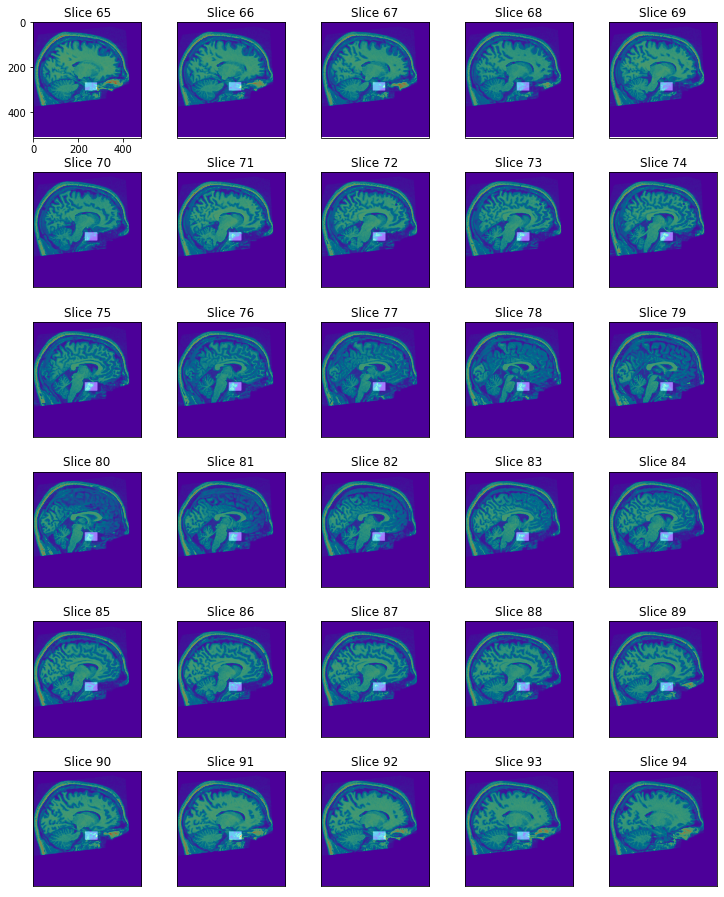

In [159]:
viz_ras(moving_mr_arr, bin_mask_arr=moving_mask_arr, 
        slices=range(65, 95), view=0, \
        fn = np.rot90, \
        nrows=6, ncols=5, hspace=0.3, fig_mult=2)

## Viz Moving vs Fixed

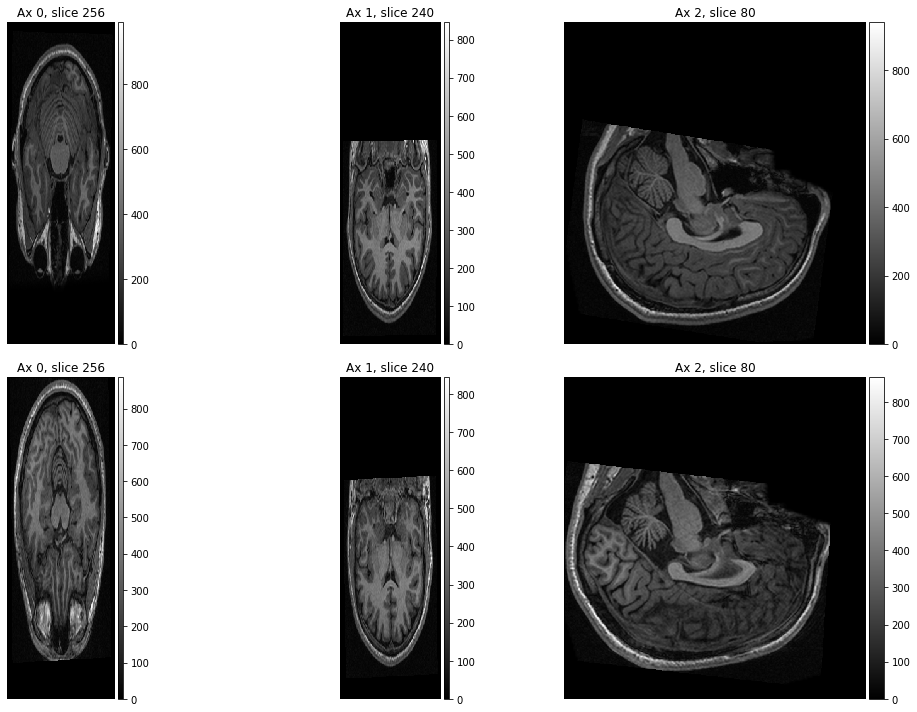

(<Figure size 1080x720 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f063897b390>,
       dtype=object))

In [25]:
slices, titles = viz_objs([fixed_obj, moving_obj])
ne.plot.slices(slices, titles=titles, grid=[2,3], \
               cmaps=['gray'], do_colorbars=True)

# Re-orient

In [26]:
# re-orient
orientation_filter = sitk.DICOMOrientImageFilter()
orientation_filter.SetDesiredCoordinateOrientation("LPI") # RAI

re_ct_obj = orientation_filter.Execute(fixed_obj)
re_mr_obj = orientation_filter.Execute(moving_obj)


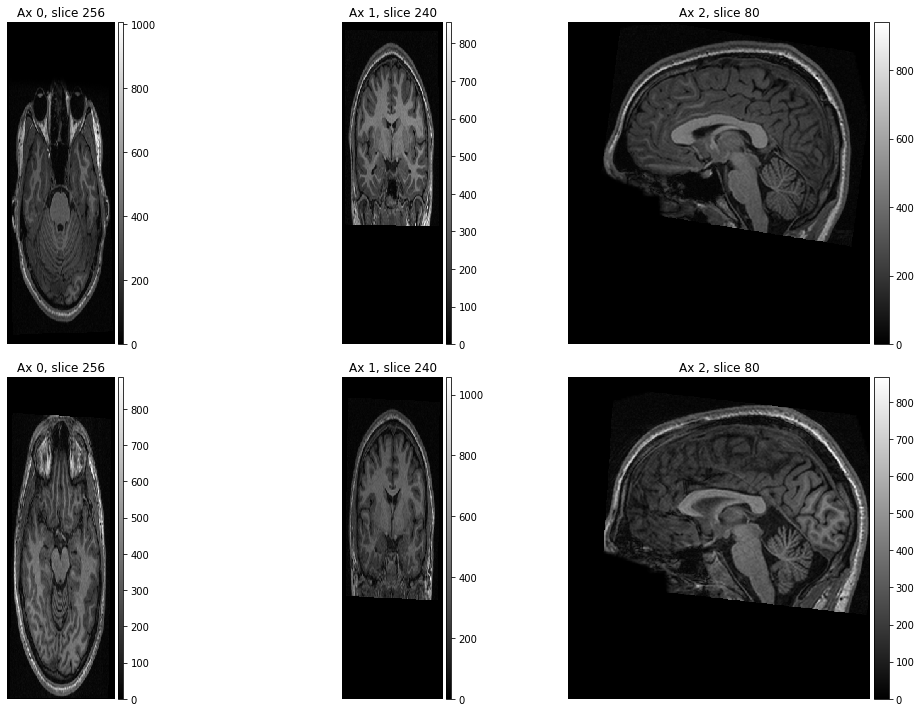

(<Figure size 1080x720 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062e627b90>,
       dtype=object))

In [27]:
slices, titles = viz_objs([re_ct_obj, re_mr_obj])
ne.plot.slices(slices, titles=titles, grid=[2,3], \
               cmaps=['gray'], do_colorbars=True)

# Isotropic

In [28]:
standard_spacing = (1,1,1)
#standard_size = (160, 192, 224) # voxelmorph size


# http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/05_Results_Visualization.html

interpolator = sitk.sitkLinear # sitk.sitkBSPling

def get_isotropic(obj):
  """ returns obj w/ 1mm isotropic voxels """

  original_size    = obj.GetSize()
  original_spacing = obj.GetSpacing()

  new_spacing = standard_spacing
  min_spacing = min(new_spacing)

  new_size = [int(round(osz*ospc/min_spacing)) for osz,ospc in zip(original_size, original_spacing)]

  return sitk.Resample(obj, new_size, sitk.Transform(), interpolator,
                         obj.GetOrigin(), new_spacing, obj.GetDirection(), 0,
                         obj.GetPixelID())

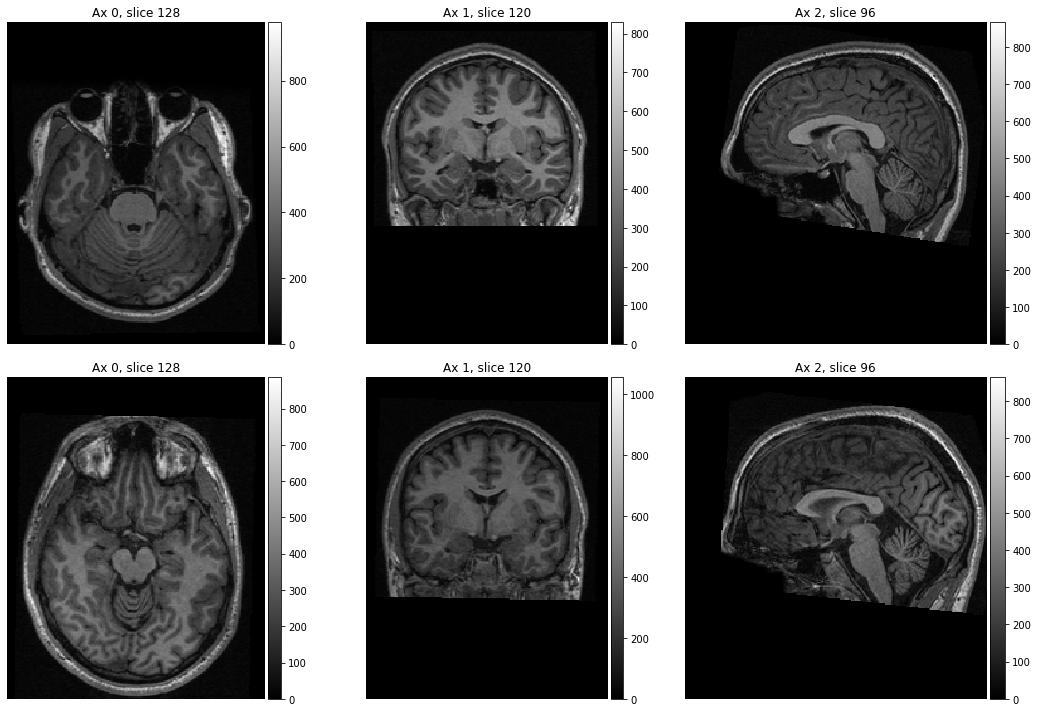

(<Figure size 1080x720 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062c552c90>,
       dtype=object))

In [29]:
re_iso_ct_obj = get_isotropic(re_ct_obj)
re_iso_mr_obj = get_isotropic(re_mr_obj)

slices, titles = viz_objs([re_iso_ct_obj, re_iso_mr_obj])
ne.plot.slices(slices, titles=titles, grid=[2,3], \
               cmaps=['gray'], do_colorbars=True)

In [30]:
print("#" * 10, "LPI & Isotropic ", "#" * 10)
print(f"ct vol shape: {re_iso_ct_obj.GetSize()}")
print(f"ct vol spacing: {re_iso_ct_obj.GetSpacing()}")
print(f"ct orientation: {re_iso_ct_obj.GetDirection()}")
print()
print(f"mr vol shape: {re_iso_mr_obj.GetSize()}")
print(f"mr vol spacing: {re_iso_mr_obj.GetSpacing()}")
print(f"mr orientation: {re_iso_mr_obj.GetDirection()}")

########## LPI & Isotropic  ##########
ct vol shape: (192, 240, 256)
ct vol spacing: (1.0, 1.0, 1.0)
ct orientation: (0.9996102045738705, 0.0, 0.027918432437759207, 0.0, 1.0, 0.0, 0.02791843319000612, 0.0, -0.9996102045948803)

mr vol shape: (192, 240, 256)
mr vol spacing: (1.0, 1.0, 1.0)
mr orientation: (0.999444084952182, -0.02268730996066288, 0.024429634641862347, 0.0226805372107988, 0.9997426098585296, 0.000554315813759058, 0.024435922039593477, -6.962904443646944e-08, -0.9997013982611226)


# Mask re-orient and isotropic

In [70]:
# numpy mask into sitk

def np2sitk(mask_arr, sitk_image):
  obj = sitk.GetImageFromArray(mask_arr)
  obj.SetOrigin(sitk_image.GetOrigin())
  obj.SetSpacing(sitk_image.GetSpacing())   
  obj.SetDirection(sitk_image.GetDirection())

  return obj

In [89]:
# load masks
fixed_mask_arr =  np.load(f"{PROJ_PATH}/binary_segmentation_mask.npy")
moving_np_arr, moving_mask_arr = seg2mask(moving_mr_file, segm_path)

In [116]:
moving_arr = sitk.GetArrayFromImage(moving_obj)
aa = np.swapaxes(moving_np_arr, 0, 2)

# check if sitk just swaps axes
print(moving_np_arr.shape, moving_arr.shape)
print(np.array_equal(aa, moving_arr.shape))
print(np.amax(aa-moving_arr, axis=(0,1,2)))
print(np.unique(aa-moving_arr))

In [118]:
# convert to int
fixed_mask_arr  = fixed_mask_arr.astype(int)
moving_mask_arr = moving_mask_arr.astype(int)

# swap axes for sitk
fixed_mask_arr  = np.swapaxes(fixed_mask_arr, 0, 2)
moving_mask_arr = np.swapaxes(moving_mask_arr, 0, 2)

# convert to sitk obj
fixed_mask_obj  = np2sitk(fixed_mask_arr, fixed_obj)
moving_mask_obj = np2sitk(moving_mask_arr, moving_obj)

# check sizes match between mr and mask objs

# mr objs
fixed_arr  = sitk.GetArrayFromImage(fixed_obj)
moving_arr = sitk.GetArrayFromImage(moving_obj)

# mask objs
fixed_mask_arr_sitk  = sitk.GetArrayFromImage(fixed_mask_obj)
moving_mask_arr_sitk = sitk.GetArrayFromImage(moving_mask_obj)

# comparison
print(fixed_mask_arr_sitk.shape, fixed_arr.shape)
print(moving_mask_arr_sitk.shape, moving_arr.shape)

(512, 480, 160) (512, 480, 160)
(512, 480, 160) (512, 480, 160)


In [120]:
# re-orient masks w/ same orientation filter
re_fixed_mask_obj  = orientation_filter.Execute(fixed_mask_obj)
re_moving_mask_obj = orientation_filter.Execute(moving_mask_obj)

# make masks iso-tropic
re_iso_fixed_mask_obj  = get_isotropic(re_fixed_mask_obj)
re_iso_moving_mask_obj = get_isotropic(re_moving_mask_obj)

# slices, titles = viz_objs([re_iso_fixed_mask_obj, re_iso_moving_mask_obj])
# ne.plot.slices(slices, titles=titles, grid=[2,3], \
#                cmaps=['gray'], do_colorbars=True)

## Viz re iso masks

In [121]:
re_iso_fixed_mask_arr  = sitk.GetArrayFromImage(re_iso_fixed_mask_obj)
re_iso_moving_mask_arr = sitk.GetArrayFromImage(re_iso_moving_mask_obj)

re_iso_fixed_mr_arr  = sitk.GetArrayFromImage(re_iso_ct_obj)
re_iso_moving_mr_arr = sitk.GetArrayFromImage(re_iso_mr_obj)

In [122]:
print(re_iso_fixed_mask_arr.shape,
re_iso_fixed_mr_arr.shape,
re_iso_moving_mask_arr.shape,
re_iso_moving_mr_arr.shape)

(256, 240, 192) (256, 240, 192) (256, 240, 192) (256, 240, 192)


In [168]:
# see which slices contain ROI

# given ROI for fixed
print(f"Fixed ROI (given) contains {np.count_nonzero(re_iso_fixed_mask_arr)} elements")
print(f"Slices of interest: ", np.unique(np.nonzero(re_iso_fixed_mask_arr)[2]))

# given ROI for moving
print(f"Moving ROI (given) contains {np.count_nonzero(re_iso_moving_mask_arr)} elements")
print(f"Slices of interest: ", np.unique(np.nonzero(re_iso_moving_mask_arr)[2]))

Fixed ROI (given) contains 44297 elements
Slices of interest:  [ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114]
Moving ROI (given) contains 16525 elements
Slices of interest:  [ 78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111]


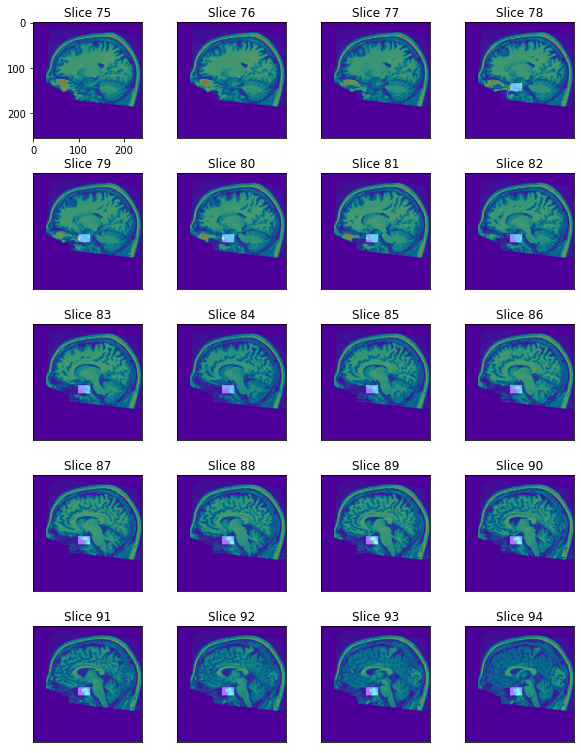

In [169]:
viz_ras(re_iso_moving_mr_arr, bin_mask_arr=re_iso_moving_mask_arr, \
        slices=range(75, 95), view=2, \
        nrows=5, ncols=4, hspace=0.3, fig_mult=2)

# Rigid Align

In [179]:
#read the images
fixed_image  =  sitk.Cast(re_iso_ct_obj, sitk.sitkFloat32)
moving_image = sitk.Cast(re_iso_mr_obj, sitk.sitkFloat32)

# mask rois
fixed_mask_image  = sitk.Cast(re_iso_fixed_mask_obj, sitk.sitkFloat32)
moving_mask_image = sitk.Cast(re_iso_moving_mask_obj, sitk.sitkFloat32)

Use the CenteredTransformInitializer to align the centers of the two volumes and set the center of rotation to the center of the fixed image.

In [ ]:
# useful:
- http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/63_Registration_Initialization.html

Transform maps points from fixed to moving.

"transform in a resampling operation defines the transform from the output space to the input space" (http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/21_Transforms_and_Resampling.html)

In [187]:
# source: http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/60_Registration_Introduction.html
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

#moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# inverse: moving => fixed, reversed in resample: fixed => moving
inverse_transform = initial_transform.GetInverse()
generated_moving_mask = sitk.Resample(fixed_mask_image, moving_mask_image, inverse_transform, \
                                      sitk.sitkLinear, 0.0, fixed_mask_image.GetPixelID())

# Generated ROI

In [188]:
generated_moving_mask_arr  = sitk.GetArrayFromImage(generated_moving_mask)
print(generated_moving_mask_arr.shape)

(256, 240, 192)


In [189]:
# see which slices contain ROI

# generated ROI for moving
print(f"Moving ROI (generated) contains {np.count_nonzero(generated_moving_mask_arr)} elements")
print(f"Slices of interest: ", np.unique(np.nonzero(generated_moving_mask_arr)[2]))

# given ROI for moving
print(f"Moving ROI (given) contains {np.count_nonzero(re_iso_moving_mask_arr)} elements")
print(f"Slices of interest: ", np.unique(np.nonzero(re_iso_moving_mask_arr)[2]))

# given ROI for fixed
print(f"Fixed ROI (given) contains {np.count_nonzero(re_iso_fixed_mask_arr)} elements")
print(f"Slices of interest: ", np.unique(np.nonzero(re_iso_fixed_mask_arr)[2]))

Moving ROI (generated) contains 48206 elements
Slices of interest:  [ 74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115]
Moving ROI (given) contains 16525 elements
Slices of interest:  [ 78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
Fixed ROI (given) contains 44297 elements
Slices of interest:  [ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114]


# Viz ROI diff

In [ ]:
# binary mask 1 => cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "yellow"])
# binary mask 2 => cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "blue"])

In [215]:
len((73,74,75,77,78,108,109,110,111,112))

10

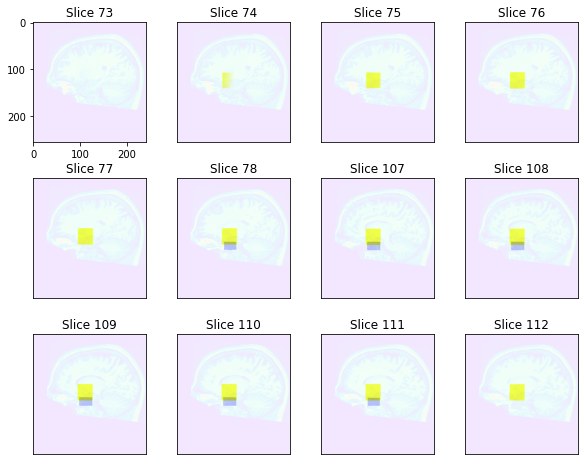

In [222]:
interesting_slices = (73,74,75,77,78,108,109,110,111,112)

viz_ras(re_iso_moving_mr_arr, bin_mask_arr=generated_moving_mask_arr, \
        bin_mask_arr2 = re_iso_moving_mask_arr, \
        slices=(73,74,75,76,77,78,107,108,109,110,111,112), view=2, \
        nrows=3, ncols=4, hspace=0.3, fig_mult=2)

In [ ]:
# generated_moving_mask_arr


## ROI Transform

In [128]:
# source: https://stackoverflow.com/questions/52076168/simpleitk-apply-inverse-transformation

# inverse_transform = final_transform_v4.GetInverse()

# transformed_labels = sitk.Resample(re_iso_fixed_mask_obj,
#                                    re_iso_moving_mask_obj,
#                                    inverse_transform, 
#                                    sitk.sitkNearestNeighbor,
#                                    0.0, #out of bounds pixel color
#                                    re_iso_fixed_mask_obj.GetPixelID())

In [129]:
mask_resampler = sitk.ResampleImageFilter()
mask_resampler.SetReferenceImage(fixed_mask_obj)
mask_resampler.SetInterpolator(sitk.sitkNearestNeighbor)
mask_resampler.SetDefaultPixelValue(fixed_mask_obj.GetPixelIDValue())
mask_resampler.SetTransform(final_transform_v4)

out_mask = mask_resampler.Execute(moving_mask_obj)

In [130]:
out_mask_arr = sitk.GetArrayFromImage(out_mask)

In [133]:
out_mask_arr.shape, moving_mask_arr.shape

((512, 480, 160), (512, 480, 160))

In [132]:
ne.plot()

(512, 480, 160)

In [ ]:
transformed_labels = sitk.Resample(re_iso_fixed_mask_obj,
                                   re_iso_moving_mask_obj,
                                   inverse_transform, 
                                   sitk.sitkNearestNeighbor,
                                   0.0, #out of bounds pixel color
                                   re_iso_fixed_mask_obj.GetPixelID())

# Advanced

In [173]:
# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
# registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
# registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
# registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
# registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                               sitk.Cast(moving_image, sitk.sitkFloat32))

In [174]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.33193995872173027
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [175]:
# use Bspline?
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

In [45]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

# NOT FINAL INTERPOLATOR -- set to BSPLINE
registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial moving and optimized transforms.
optimized_transform = sitk.Euler3DTransform()    
registration_method.SetMovingInitialTransform(initial_transform)
registration_method.SetInitialTransform(optimized_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
# registration_method.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
# registration_method.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
# registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations) 
# registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rgui.plot_values(registration_method))

# Need to compose the transformations after registration.
final_transform_v4 = registration_method.Execute(fixed_image, moving_image)
#final_transform_v4.AddTransform(initial_transform)

# Always check the reason optimization terminated.
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.561222870306804
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


## Resample moving

In [46]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed_image)
# CHANGE FINAL INTERPOLATOR TO BSLINE
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(fixed_image.GetPixelIDValue())
resampler.SetTransform(final_transform_v4)

out = resampler.Execute(moving_image)
simg1 = sitk.Cast(sitk.RescaleIntensity(fixed_image), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
#sitk.Show(cimg, "ImageRegistration1 Composition")

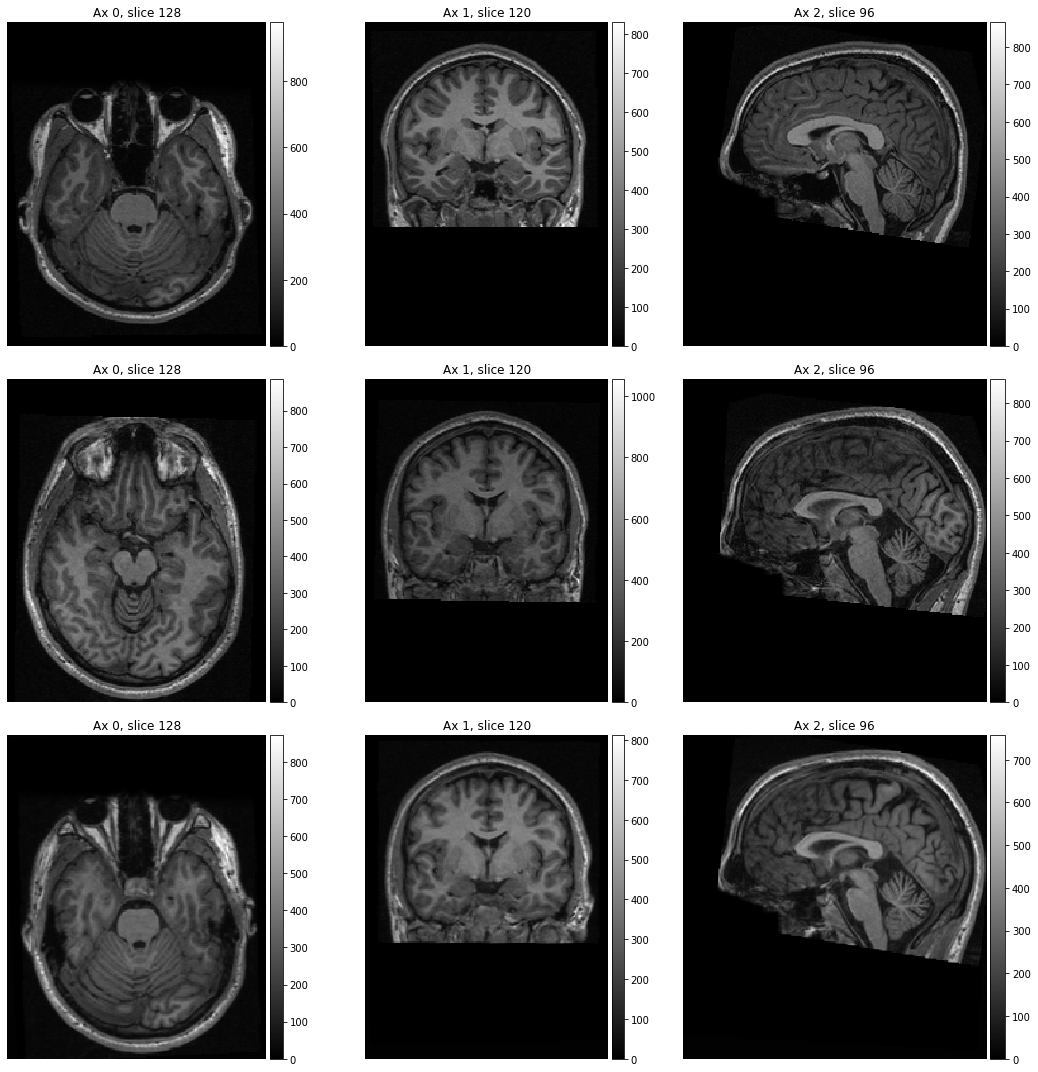

(<Figure size 1080x1080 with 18 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05c10694d0>,
       dtype=object))

In [47]:
slices, titles = viz_objs([fixed_image, moving_image, out])
ne.plot.slices(slices, titles=titles, grid=[3,3], \
               cmaps=['gray'], do_colorbars=True)

In [ ]:
mask_resampler = sitk.ResampleImageFilter()
mask_resampler.SetReferenceImage(fixed_image)
mask_resampler.SetInterpolator(sitk.sitkLinear)
mask_resampler.SetDefaultPixelValue(fixed_image.GetPixelIDValue())
mask_resampler.SetTransform(final_transform_v4)

out = mask_resampler.Execute(moving_image)
simg1 = sitk.Cast(sitk.RescaleIntensity(fixed_image), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
#sitk.Show(cimg, "ImageRegistration1 Composition")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


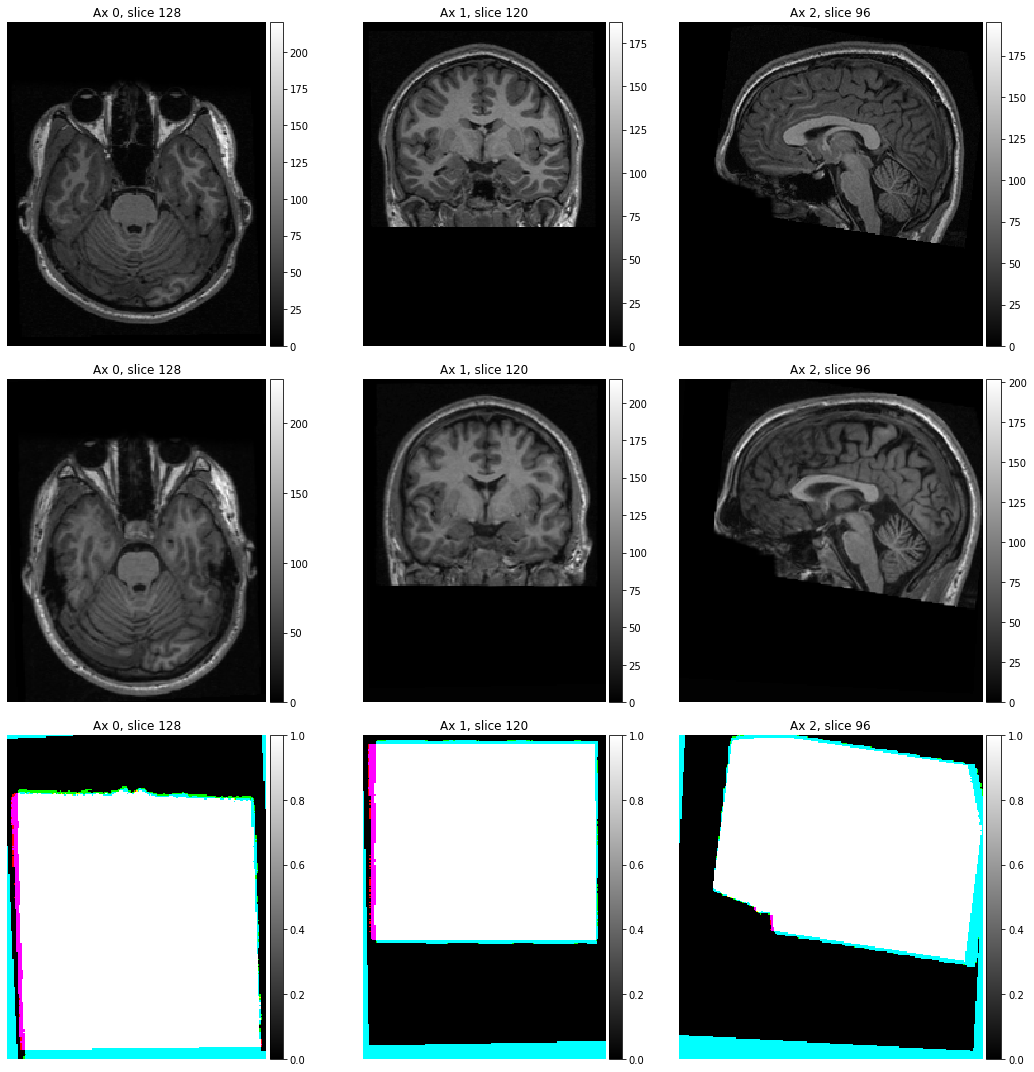

(<Figure size 1080x1080 with 18 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05c0a46350>,
       dtype=object))

In [49]:
slices, titles = viz_objs([simg1, simg2, cimg])
ne.plot.slices(slices, titles=titles, grid=[3,3], \
               cmaps=['gray'], do_colorbars=True)

# END

# Elastix Align

In [41]:
# source: https://discourse.itk.org/t/in-python-how-to-convert-between-simpleitk-and-itk-images/1922/2

image_dimension = 3

def sitk2itk(sitk_image):
  # Create an itk image from the simpleitk image via numpy array
  itk_image = itk.GetImageFromArray(sitk.GetArrayFromImage(sitk_image), is_vector = sitk_image.GetNumberOfComponentsPerPixel()>1)
  itk_image.SetOrigin(sitk_image.GetOrigin())
  itk_image.SetSpacing(sitk_image.GetSpacing())   
  itk_image.SetDirection(itk.GetMatrixFromArray(np.reshape(np.array(sitk_image.GetDirection()), [image_dimension]*2)))
  #print('ITK image value at {0}: {1}'.format(index, itk_image.GetPixel(index)))

  # Change the pixel value
  #itk_image.SetPixel(index, 888)
  return itk_image

In [42]:
fixed_itk_obj = sitk2itk(re_iso_ct_obj)
moving_itk_obj = sitk2itk(re_iso_mr_obj)

In [32]:
parameter_object = itk.ParameterObject.New()
default_rigid_parameter_map = parameter_object.GetDefaultParameterMap('rigid')
parameter_object.AddParameterMap(default_rigid_parameter_map)

In [ ]:
result_image, result_transform_parameters = itk.elastix_registration_method(
    fixed_image, moving_image,
    parameter_object=parameter_object,
    log_to_console=False)

# Rigid Align

In [ ]:
movingImage = ct_obj
fixedImage  = mr_obj

In [ ]:
parameterMap = sitk.GetDefaultParameterMap('translation')

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixedImage)
elastixImageFilter.SetMovingImage(movingImage)
elastixImageFilter.SetParameterMap(parameterMap)
elastixImageFilter.Execute()

resultImage = elastixImageFilter.GetResultImage()
transformParameterMap = elastixImageFilter.GetTransformParameterMap()

AttributeError: ignored

# Voxelmorph 

Model settings

In [ ]:
# set trainin data dimensions to (192, 256, 256)
vxm_data_shape = (160, 192, 224) # pre-trained model (192, 256, 256)
vxm_data_spacing = (1,1,1) # isotropic 1 mm for consistency

# simple itk data shape - reverse
itk_data_shape = (224, 192, 160) #(160, 192, 224) #(256, 256, 192)

# encoder/decoder layers
nb_features = [
    [16, 32, 32, 32], # encoder
    [32, 32, 32, 32, 32, 16, 16] # decoder
]

# build vxm network
vxm_model = vxm.networks.VxmDense(vxm_data_shape, nb_features, int_steps=0);